# 容量制約付き施設配置問題

全国各地に店舗展開しているチェーン店Aがある。6つの顧客があり、3つの倉庫から輸送を考えている。  
顧客iの需要は  
di = [50, 100, 60, 80, 120, 90]  
工場jから各顧客iまでの輸送量は  
cij = {(1,1):6, (2,1):4, (3,1):8, (4,1):7, (5,1):6, (6,1):7,  
    (1,2):5, (2,2):6, (3,2):7, (4,2):4, (5,2):8, (6,2):6,  
    (1,3):6, (2,3):7, (3,3):5, (4,3):7, (5,3):6, (6,3):8  
}  
また工場の開設費用fjと、容量Mjは  
fj = [500, 500, 500]  
Mj = [200, 200, 200]  
この時顧客の需要と工場の容量制約を満たしつつ、工場の輸送費用と開設費用の和を最小にする値を求めてください

In [2]:
from gurobipy import*



In [11]:
def make_data():
    I, d = multidict({1:50,2:100,3:60,4:80,5:120,6:90})
    J, M, f = multidict({1:[200,500],2:[200,500],3:[200,500]})
    c = {(1,1):6, (2,1):4, (3,1):8, (4,1):7, (5,1):6, (6,1):7,  
        (1,2):5, (2,2):6, (3,2):7, (4,2):4, (5,2):8, (6,2):6,  
        (1,3):6, (2,3):7, (3,3):5, (4,3):7, (5,3):6, (6,3):8  
        }  
    return I, J, d, M, f, c
    


In [12]:
def flp(I, J, d, M, f, c):
    model=Model("flp")
    x,y={},{}
    for j in J:
        y[j]=model.addVar(vtype="B")
        for i in I:
            x[i,j]=model.addVar(vtype="C")
    model.update()
    #制約式
    for i in I:
        model.addConstr(quicksum(x[i,j] for j in J)==d[i])
    for j in J:
        model.addConstr(quicksum(x[i,j] for i in I)<=M[j]*y[j])
    for (i,j) in x:
        model.addConstr(x[i,j]<=d[i]*y[j])
    #目的関数
    model.setObjective(quicksum(f[j]*y[j]for j in J)+quicksum(c[i,j]*x[i,j] for i in I for j in J),GRB.MINIMIZE)
    model.__data=x,y
    return model

    

In [13]:
#メイン関数
if __name__ =="__main__":
    I, J, d, c, f, M = make_data()
    model=flp(I, J, d, c, f, M)
    model.optimize()
    print("Optimal value:", model.Objval)
    x = model.__data[0]
    for (i,j) in x:
        if x[i,j].X > 0:
            print("setting quantity %10s from factory %3s to customer %3s" % (x[i,j].X, j,i))


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 21 columns and 75 nonzeros
Model fingerprint: 0x8700a3bf
Variable types: 18 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 1e+02]
Presolve time: 0.00s
Presolved: 27 rows, 21 columns, 75 nonzeros
Variable types: 18 continuous, 3 integer (3 binary)
Found heuristic solution: objective 4050.0000000

Root relaxation: objective 3.890000e+03, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3890.00000    0    1 4050.00000 3890.00000  3.95%     -    0s
     0     0 4050.00000    0    1 4050.00000 4050.00000  0.

# k-センター問題
下記のプログラムを実行して、どのような挙動をしているか理解してください

Note: you may need to restart the kernel to use updated packages.
Set parameter Cutoff to value 0.1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 931 rows, 960 columns and 2760 nonzeros
Model fingerprint: 0xa448d57f
Variable types: 0 continuous, 960 integer (960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 262 rows and 263 columns
Presolve time: 0.00s
Presolved: 669 rows, 697 columns, 1973 nonzeros
Variable types: 0 continuous, 697 integer (697 binary)

Root relaxation: objective 4.050482e-03, 262 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0              

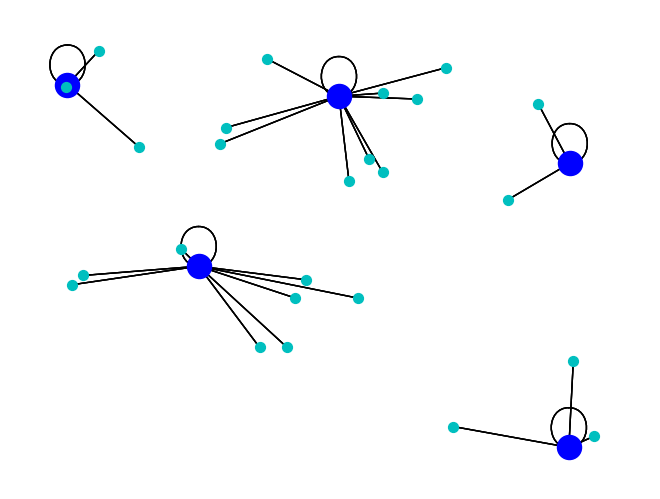

In [10]:
import math
import random
from gurobipy import*
%pip install networkx
import networkx as nx
import matplotlib

def kcover(I,J,c,k):
    """kcover -- minimize the number of uncovered
    customers from k facilities.
    Parameters:
        - I: set of customers
        - J: set of potential facilities
        - c[i,j]: cost of servicing customer i from facility j
        - k: number of facilities to be used
    Returns a model, ready to be solved.
    """

    model = Model("k-center")

    z,y,x = {},{},{}
    for i in I:
        z[i] = model.addVar(vtype="B", name="z(%s)"%i)
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="B",
                                  name="x(%s,%s)"%(i,j))
    model.update()

    for i in I:
        model.addConstr(quicksum(x[i,j] for j in J) + z[i] == 1,
                        "Assign(%s)"%i)
        for j in J:
            model.addConstr(x[i,j] <= y[j],
                            "Strong(%s,%s)"%(i,j))

    model.addConstr(quicksum(y[j] for j in J) == k,
                    "k_center")

    model.setObjective(quicksum(z[i] for i in I)+
                       0.001*quicksum(c[i,j]*x[i,j]
                    for (i,j) in x), GRB.MINIMIZE)

    model.update()
    model.__data = x,y,z
    return model

def solve_kcenter(I,J,c,k,delta):
    """solve_kcenter -- locate k facilities minimizing
    distance of most distant customer.
    Parameters:
        I - set of customers
        J - set of potential facilities
        c[i,j] - cost of servicing customer i from facility j
        k - number of facilities to be used
        delta - tolerance for terminating bisection
    Returns:
        - list of facilities to be used
        - edges linking them to customers
    """

    model = kcover(I,J,c,k)
    x,y,z = model.__data

    facilities,edges = [],[]
    LB = 0
    UB = max(c[i,j] for (i,j) in c)
    while UB-LB > delta:
        theta = (UB+LB) / 2.
        # print "\n\ncurrent theta:", theta
        for j in J:
            for i in I:
                if c[i,j]>theta:
                    x[i,j].UB = 0
                else:
                    x[i,j].UB = 1.0
        model.update()
        # model.Params.OutputFlag = 0 # silent mode
        model.Params.Cutoff = .1
        model.optimize()

        if model.status == GRB.Status.OPTIMAL:
            # infeasibility = sum([z[i].X for i in I])
            # print "infeasibility=",infeasibility
            UB = theta
            facilities = [j for j in y if y[j].X > .5]
            edges = [(i,j) for (i,j) in x if x[i,j].X > .5]
            # print "updated solution:"
            # print "facilities",facilities
            # print "edges",edges
        else:   # infeasibility > 0:
            LB = theta

    return facilities,edges
def distance(x1,y1,x2,y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

def make_data(n,m,same=True):
    if same == True:
        I = range(n)
        J = range(m)
        x = [random.random() for i in range(max(m,n))]
        # positions of the points in the plane
        y = [random.random() for i in range(max(m,n))]
    else:
        I = range(n)
        J = range(n,n+m)
        x = [random.random() for i in range(n+m)]
        # positions of the points in the plane
        y = [random.random() for i in range(n+m)]
    c = {}
    for i in I:
        for j in J:
            c[i,j] = distance(x[i],y[i],x[j],y[j])

    return I,J,c,x,y

random.seed(2)
n = 30
m = n
I,J,c,x_pos,y_pos = make_data(n,m,same=True)
k = 5
delta = 1.e-4
facilities,edges = solve_kcenter(I,J,c,k,delta)
print ("Selected facilities:",facilities)
print ("Max distance from a facility to a customer: ",
       max([c[i,j] for (i,j) in edges]))

G = nx.Graph()
facilities = set(facilities)
unused = set(j for j in J if j not in facilities)
client = set(i for i in I if i not in facilities
             and i not in unused)
G.add_nodes_from(facilities)
G.add_nodes_from(client)
G.add_nodes_from(unused)
for (i,j) in edges:
    G.add_edge(i,j)

position = {}
for i in range(len(x_pos)):
    position[i] = (x_pos[i],y_pos[i])

nx.draw(G,position,with_labels=False,node_color="b",
        nodelist=facilities)
nx.draw(G,position,with_labels=False,node_color="c",
        nodelist=unused,node_size=50)
nx.draw(G,position,with_labels=False,node_color="g",
        nodelist=client,node_size=50)